In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import re

pd.set_option('display.max_columns', None)  # to display all rows and columns while printing.
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)

params = {'legend.fontsize': '15',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
        #  'axes.prop_cycle': plt.cycler(color = plt.cm.Set2.colors),
        #  'image.cmap': 'Set2',
         'figure.figsize': (18, 7)}
plt.rcParams.update(params)

# plt.rcParams["image.cmap"] = "Set1"

# to change default color cycle
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
# plt.rcParams['figure.figsize'] = 18, 7

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.style.use('dark_background')  # to change the default values of plt to our interest.

Read the data.

In [4]:
df = pd.read_csv('../input/quantium-cleaned-dataset-part2/df1.csv', parse_dates= ['date'])
df.head()

,date,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,lifestage,premium_customer,prod_wt,prod_comp,prod_price
0,2018-10-17,1,1000,1,5,natural_chipco seasalt,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural_chipco,3.00
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
2,2018-11-10,1,1307,346,96,ww original stacked chips,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,ww,1.90
3,2019-03-09,1,1307,347,54,ccs original,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
4,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,smiths,1.45


Inserted a column 'year_month' in the dataframe.

In [5]:
df.insert(1, 'year_month',df['date'].dt.to_period('M'))     # .dt.to_period('M')
df.head()

,date,year_month,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,lifestage,premium_customer,prod_wt,prod_comp,prod_price
0,2018-10-17,2018-10,1,1000,1,5,natural_chipco seasalt,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural_chipco,3.00
1,2019-05-14,2019-05,1,1307,348,66,ccs nacho cheese,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
2,2018-11-10,2018-11,1,1307,346,96,ww original stacked chips,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,ww,1.90
3,2019-03-09,2019-03,1,1307,347,54,ccs original,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
4,2019-05-20,2019-05,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,smiths,1.45


We have changed dtypes for simplicity  and easier operations.

In [6]:
cols_with_changed_dtype = {'prod_name': 'category', 'prod_qty': 'category',
                           'lifestage': 'category', 'premium_customer': 'category',
                           'prod_comp': 'category'}
df = df.astype(cols_with_changed_dtype)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249668 entries, 0 to 249667
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              249668 non-null  datetime64[ns]
 1   year_month        249668 non-null  period[M]     
 2   store_nbr         249668 non-null  int64         
 3   lylty_card_nbr    249668 non-null  int64         
 4   txn_id            249668 non-null  int64         
 5   prod_nbr          249668 non-null  int64         
 6   prod_name         249668 non-null  category      
 7   prod_qty          249668 non-null  category      
 8   tot_sales         249668 non-null  float64       
 9   lifestage         249668 non-null  category      
 10  premium_customer  249668 non-null  category      
 11  prod_wt           249668 non-null  int64         
 12  prod_comp         249668 non-null  category      
 13  prod_price        249668 non-null  float64       
dtypes: c

We'll remove the stores which does not contain transaction data of all 12 months.

In [7]:
check = df.groupby('store_nbr')['year_month'].nunique()
check = check[check != 12]
print('Stores with less than 12 month transaction data:')
display(check)
stores_with_less_than_12_months = check.index.to_list()
del check

Stores with less than 12 month transaction data:


store_nbr
11     2 
31     2 
44     11
76     1 
85     1 
92     1 
117    11
177    11
193    3 
206    2 
218    11
252    2 
Name: year_month, dtype: int64

In [8]:
indices_to_drop = df[df['store_nbr'].isin(stores_with_less_than_12_months)].index
print(f'Shape before dropping: {df.shape}\n')
df = df.drop(indices_to_drop)
print(f'Shape after dropping: {df.shape}\n')
print(f'Number of samples that are dropped: {len(indices_to_drop)}')

Shape before dropping: (249668, 14)

Shape after dropping: (249441, 14)

Number of samples that are dropped: 227


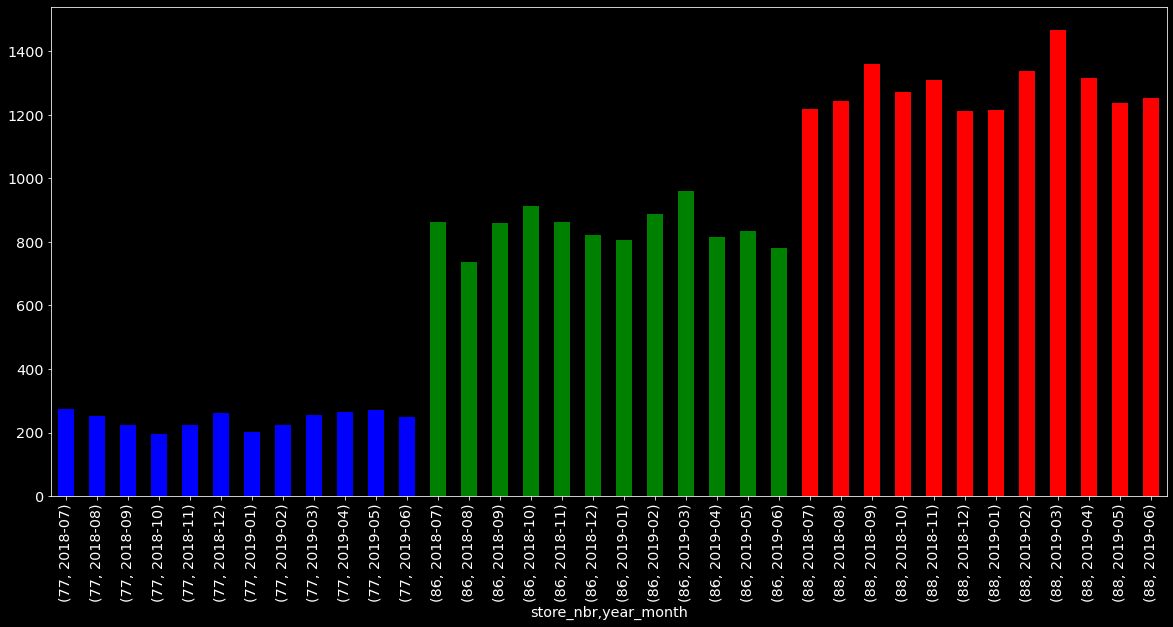

In [9]:
check = df[df['store_nbr'].isin([77, 86, 88])].groupby(['store_nbr', 'year_month'])['tot_sales'].sum() # code to plot
colors = []
for store, month in check.index:
    if store == 77:
        colors.append('b')
    elif store == 86:
        colors.append('g')
    else:
        colors.append('r')

check.plot(kind = 'bar', color = colors, figsize = (20, 9))
plt.show()
del check, colors

In [10]:
df['yearly_sale'] = df.groupby('store_nbr')['tot_sales'].transform('sum')
df['yearly_custs'] = df.groupby('store_nbr')['lylty_card_nbr'].transform('nunique')
df['monthly_sale'] = df.groupby(['store_nbr', 'year_month'])['tot_sales'].transform('sum')
df['monthly_custs'] = df.groupby(['store_nbr', 'year_month'])['lylty_card_nbr'].transform('nunique')
# df['monthly_txn'] = df.groupby(['store_nbr', 'year_month'])['txn_id'].agg({'txn_id': 'nunique'})

In [11]:
# df1 = df.copy()
# data = df.groupby(['store_nbr', 'month']).apply(lambda subdf: subdf['lylty_card_nbr'].count())
# # data['count'] = df.groupby(['store_nbr', 'month']).apply(lambda subdf: subdf['lylty_card_nbr'].count())
# data.head(25)

I need to add another column: average transaction per customer in the store.

In [12]:
avg_trans = df.groupby('store_nbr').apply(lambda subdf: (subdf['txn_id'].nunique() / subdf['yearly_custs'].unique()))
avg_trans = avg_trans.astype('float64')
df['avg_txn_per_cust'] = df['store_nbr'].map(avg_trans)

In [13]:
# store_272 = df1.groupby('store_nbr').get_group(272)
# no_of_customers = store_272['no_of_custs'].unique()
# no_of_transactions = store_272['txn_id'].nunique()
# print(f'no of customers: {no_of_customers}')
# print(f'no of transactions: {no_of_transactions}')
# print((no_of_transactions / no_of_customers).round(4))

In [14]:
df.head()

,date,year_month,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,lifestage,premium_customer,prod_wt,prod_comp,prod_price,yearly_sale,yearly_custs,monthly_sale,monthly_custs,avg_txn_per_cust
0,2018-10-17,2018-10,1,1000,1,5,natural_chipco seasalt,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural_chipco,3.00,2237.3,335,178.0,40,1.608955
1,2019-05-14,2019-05,1,1307,348,66,ccs nacho cheese,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10,2237.3,335,207.1,43,1.608955
2,2018-11-10,2018-11,1,1307,346,96,ww original stacked chips,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,ww,1.90,2237.3,335,187.5,45,1.608955
3,2019-03-09,2019-03,1,1307,347,54,ccs original,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10,2237.3,335,185.2,43,1.608955
4,2019-05-20,2019-05,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,smiths,1.45,2237.3,335,207.1,43,1.608955


"pre_df" is the dataset which contains samples only before the trial period.

"trial_df" is the datset which contains samples of trial period.

In [15]:
pre_df = df[df['date'] < "2019-02-01"]
trial_df = df[(df['date'] > "2019-01-31") & (df['date'] < "2019-05-01")]

In [16]:
min_date_in_trial_df, max_date_in_trial_df = min(trial_df['date']), max(trial_df['date'])
min_date_in_pre_df, max_date_in_pre_df =  min(pre_df['date']), max(pre_df['date'])
print(f'the trial_df dataframe consists of samples between {min_date_in_trial_df}, {max_date_in_trial_df}')
print(f'the pre_df dataframe consists of samples between {min_date_in_pre_df}, {max_date_in_pre_df}')

the trial_df dataframe consists of samples between 2019-02-01 00:00:00, 2019-04-30 00:00:00
the pre_df dataframe consists of samples between 2018-07-01 00:00:00, 2019-01-31 00:00:00


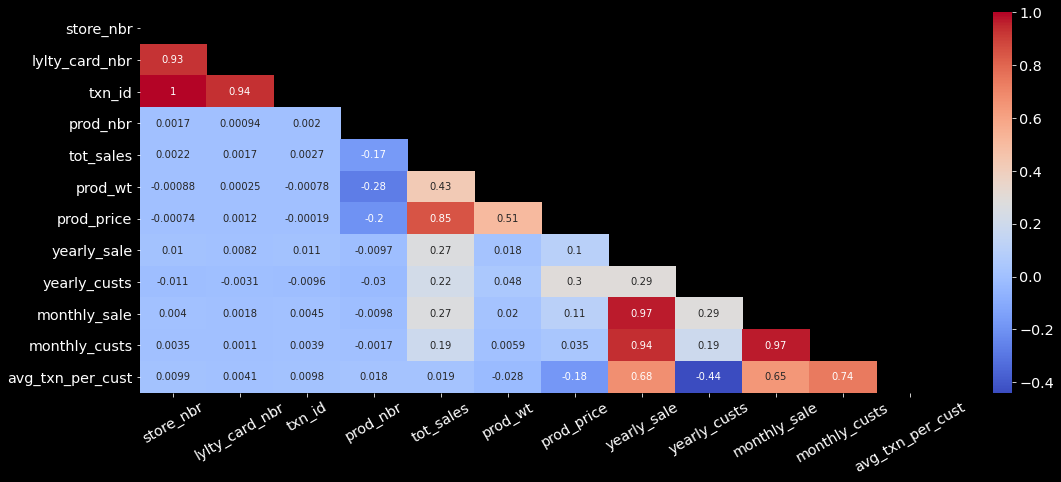

In [17]:
corrmat = pre_df.corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool))
# plt.subplots(figsize = (25, 15))
sns.heatmap(corrmat, mask = mask, cmap = 'coolwarm', annot = True)
plt.xticks(rotation = 30)
plt.show()

In [18]:
# grp = pre_df.groupby('store_nbr')
# for name, subdf in grp:
#     if name not in [77, 86, 88]:
#         #it is a control store
#         subdf
#     else:
#         # it is a trial store
#         pass

'metrics_cols' are the features for correlation and ranking between trial stores and control stores.

In [19]:
metrics_cols = ['store_nbr', 'year_month', 'yearly_sale',
                'yearly_custs','monthly_sale', 'monthly_custs', 'avg_txn_per_cust']
# metrics_data = pre_trial_data.loc[:, metrics_cols]

In [20]:
def extract_metrics(df):
    subdf = df.loc[:, metrics_cols].set_index(['store_nbr', 'year_month']).sort_values(by = ['store_nbr', 'year_month'])
    subdf.drop_duplicates(inplace = True, keep = 'first')
    return subdf 

metrics_df = extract_metrics(pre_df)
metrics_df.head()

yearly_sale  yearly_custs  monthly_sale  monthly_custs  \
store_nbr year_month                                                           
1         2018-07     2237.3       335           191.6         48              
          2018-08     2237.3       335           168.4         41              
          2018-09     2237.3       335           268.1         57              
          2018-10     2237.3       335           178.0         40              
          2018-11     2237.3       335           187.5         45              

                      avg_txn_per_cust  
store_nbr year_month                    
1         2018-07     1.608955          
          2018-08     1.608955          
          2018-09     1.608955          
          2018-10     1.608955          
          2018-11     1.608955

In [21]:
# metrics_df.xs('2018-09', level=1)

In [22]:
# metrics_df.index.get_level_values('year_month').nunique()

Function to find correlation between trial stores and control stores one by one.

In [23]:
def calc_corr(trial_store):
    '''
    input: It takes one trial store to compare other stores with.
    output: New dataframe with correlation and mean correlation.
    '''
    a=[]
    metrics = metrics_df[['monthly_sale', 'monthly_custs']] 
    for i in metrics.index:
        a.append(metrics.loc[trial_store].corrwith(metrics.loc[i[0]]))
    subdf = pd.DataFrame(a)
    subdf.index = metrics.index
    subdf = subdf.drop_duplicates()
    subdf.index = [s[0] for s in subdf.index]
    subdf.index.name ="store_nbr"
    subdf = subdf.abs()
    subdf['mean_corr'] = subdf.mean(axis=1)
    subdf.sort_values(by = 'mean_corr', ascending = False, inplace = True)
    return subdf

## Correlation with trial store: 77

In [24]:
corr_77 = calc_corr(77).drop(77)
# corr_77 = corr_77.drop(77)
corr_77.head(5)

,monthly_sale,monthly_custs,mean_corr
store_nbr,,,
233,0.976651,0.964970,0.970811
119,0.836712,0.950144,0.893428
41,0.819951,0.842018,0.830985
254,0.690476,0.956769,0.823622
50,0.917940,0.724430,0.821185


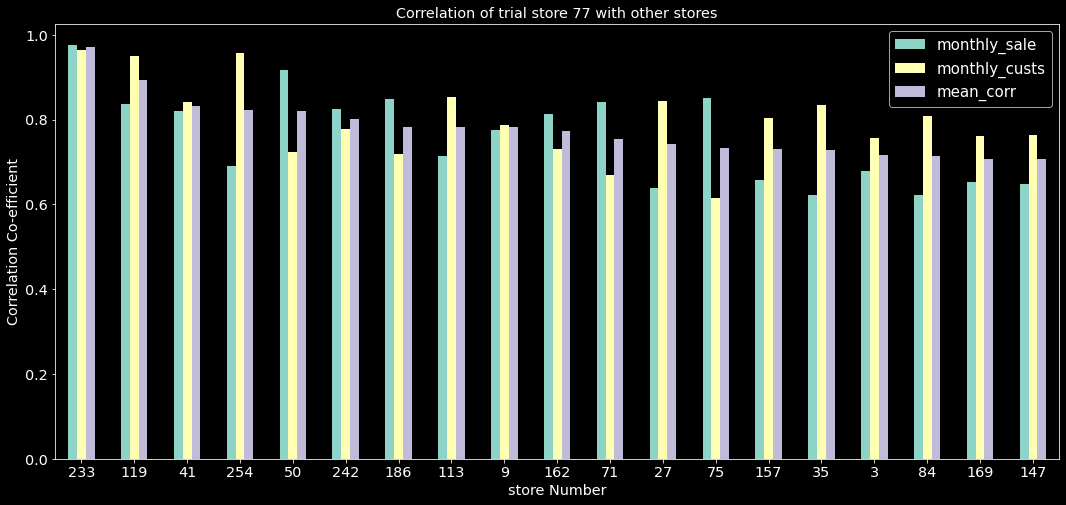

In [25]:
corr_77[corr_77['mean_corr'].abs() > 0.7].plot(kind = 'bar', rot = 0, figsize = (18, 8))
plt.title('Correlation of trial store 77 with other stores')
plt.xlabel('store Number')
plt.ylabel('Correlation Co-efficient')
plt.show()

The store '233' with the highest score is selected as the control store for trial store '77'.

Now let's quantify how related it is to the trial store by using plots and some stats. Since monthly sales and customers are only parameters we can monitor. Therefore we'll just see these two parameters.

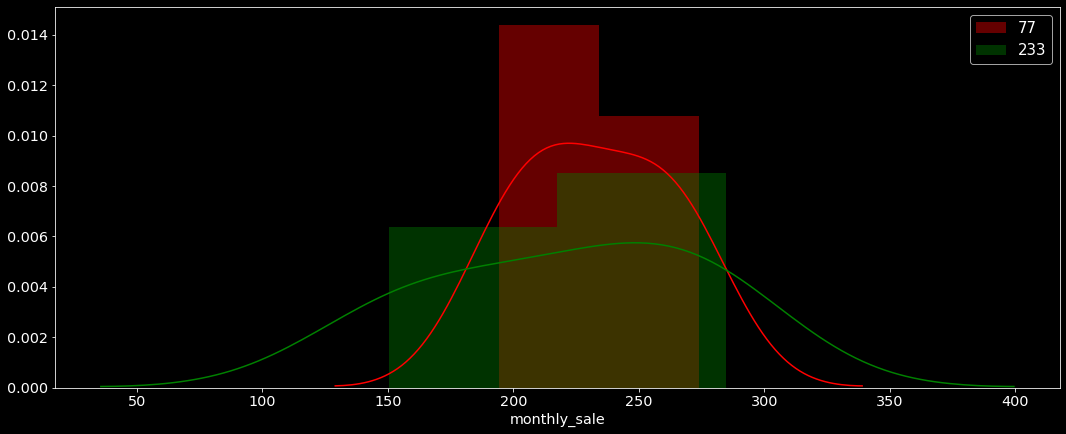

In [26]:
fig, ax = plt.subplots()
sns.distplot(metrics_df.loc[77]['monthly_sale'], color = 'r', ax = ax)
sns.distplot(metrics_df.loc[233]['monthly_sale'], color = 'g', ax = ax)
plt.legend(labels = ['77', '233'])
plt.show()

From the above plot we can see that there is difference in monthly sale in both the stores.

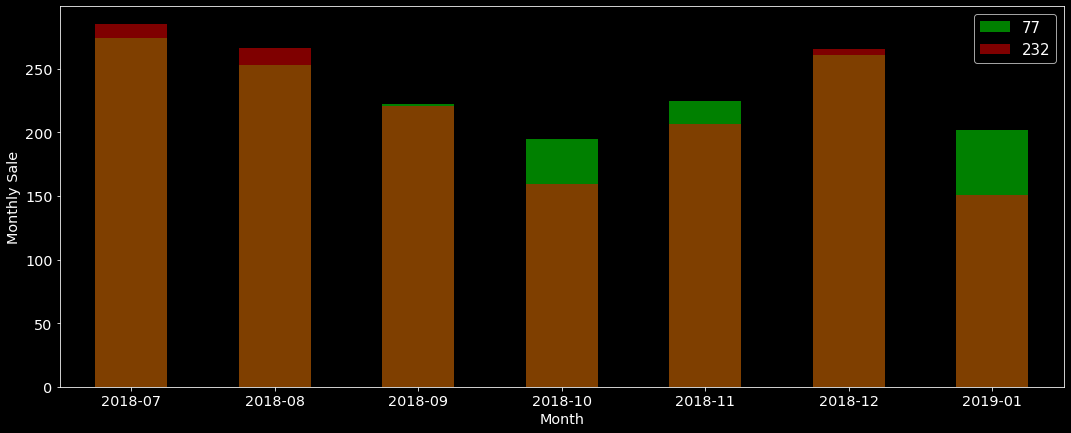

In [27]:
metrics_df.loc[77]['monthly_sale'].plot(kind = 'bar', color = 'g')
metrics_df.loc[233]['monthly_sale'].plot(kind = 'bar', color = 'r', alpha = 0.5)
plt.xticks(rotation = 0)
plt.xlabel('Month')
plt.ylabel('Monthly Sale')
plt.legend(labels = (77, 232))
plt.show()

Even though the monthly sale values are diffrent but we see a similar trend in the sales through out the period.

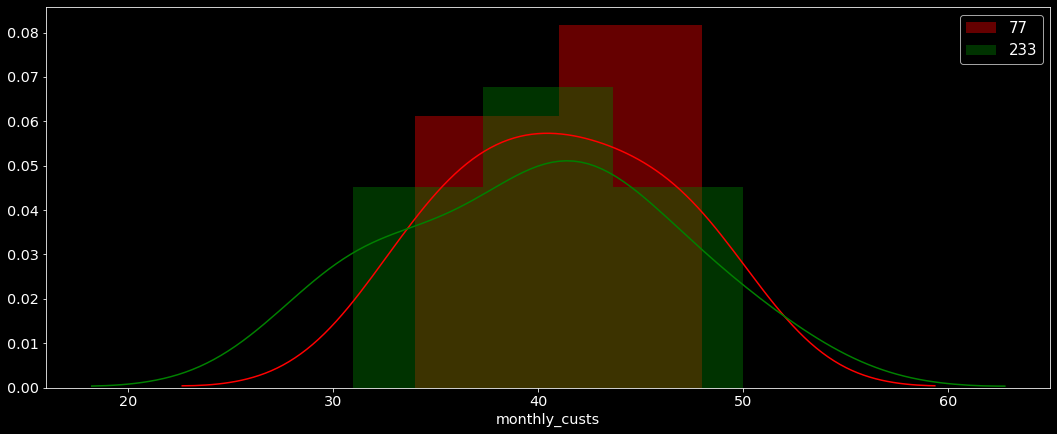

In [28]:
fig, ax = plt.subplots()
sns.distplot(metrics_df.loc[77]['monthly_custs'], color = 'r', ax = ax)
sns.distplot(metrics_df.loc[233]['monthly_custs'], color = 'g', ax = ax)
plt.legend(labels = ['77', '233'])
plt.show()

We can see that monthly customers are similar in both the stores.

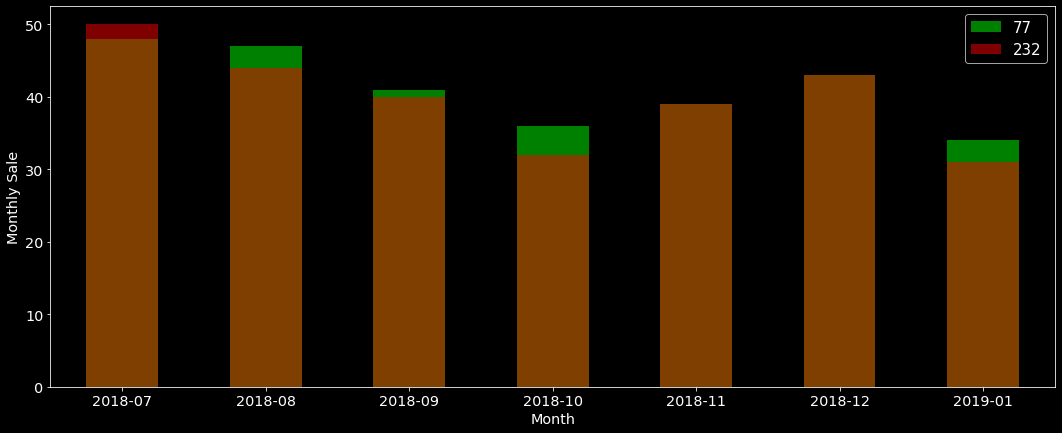

In [29]:
metrics_df.loc[77]['monthly_custs'].plot(kind = 'bar', color = 'g')
metrics_df.loc[233]['monthly_custs'].plot(kind = 'bar', color = 'r', alpha = 0.5)
plt.xticks(rotation = 0)
plt.xlabel('Month')
plt.ylabel('Monthly Sale')
plt.legend(labels = (77, 232))
plt.show()

Even the trend in the number of customers every month follows a similar trend between the stores.

Let our null hypothesis be that both the trial store and our selected control store are similar. Now if we want to reject the null hypothesis then we must have pvalue close to zero.

In [30]:
from scipy.stats import ks_2samp,ttest_ind,t

In [31]:
metrics_df.head(2)

yearly_sale  yearly_custs  monthly_sale  monthly_custs  \
store_nbr year_month                                                           
1         2018-07     2237.3       335           191.6         48              
          2018-08     2237.3       335           168.4         41              

                      avg_txn_per_cust  
store_nbr year_month                    
1         2018-07     1.608955          
          2018-08     1.608955

In [32]:
cols_under_consideration = ['monthly_sale', 'monthly_custs']
a=[]
for x in metrics_df[cols_under_consideration]:
    a.append(ks_2samp(metrics_df.loc[77][x], metrics_df.loc[233][x]))
a=pd.DataFrame(a, index = cols_under_consideration)
a.head()

,statistic,pvalue
monthly_sale,0.285714,0.962704
monthly_custs,0.285714,0.962704


From the dataframe above we can say that both are similar (pvalues are high close to 1). Hence we cannot reject our null hypothesis.

Assessment of Trial.

Now we'll compare the trial store with the control store in the trial period i.e. from Febraury 2019 to April 2019.

In [33]:
trial_metrics_df = extract_metrics(trial_df)
trial_metrics_df.head()

yearly_sale  yearly_custs  monthly_sale  monthly_custs  \
store_nbr year_month                                                           
1         2019-02     2237.3       335           194.7         49              
          2019-03     2237.3       335           185.2         43              
          2019-04     2237.3       335           177.4         39              
2         2019-02     1885.9       302           136.8         28              
          2019-03     1885.9       302           179.3         41              

                      avg_txn_per_cust  
store_nbr year_month                    
1         2019-02     1.608955          
          2019-03     1.608955          
          2019-04     1.608955          
2         2019-02     1.576159          
          2019-03     1.576159

In [34]:
b = []
for x in trial_metrics_df[cols_under_consideration]:
    b.append(ks_2samp(trial_metrics_df.loc[77][x], trial_metrics_df.loc[233][x]))
b = pd.DataFrame(b, index = cols_under_consideration)
b.head()

,statistic,pvalue
monthly_sale,0.666667,0.6
monthly_custs,0.666667,0.6


Since both the pvalues are >5 we reject the null hypothesis. Since both the stores are similar in pre-trial but not in trial period hence we reject the null hypothesis.

Comparing each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [35]:
print('critical t-value for 95% confidence level:')
t.ppf(0.95, 6)

critical t-value for 95% confidence level:


1.9431802803927816

We can see that t-value is greater than 95 percentile for febraury to april.

Therefore we can say that there was increase in sale in trial store than the control store during the trial period.

Let's plot the means for both the stores in trial period.

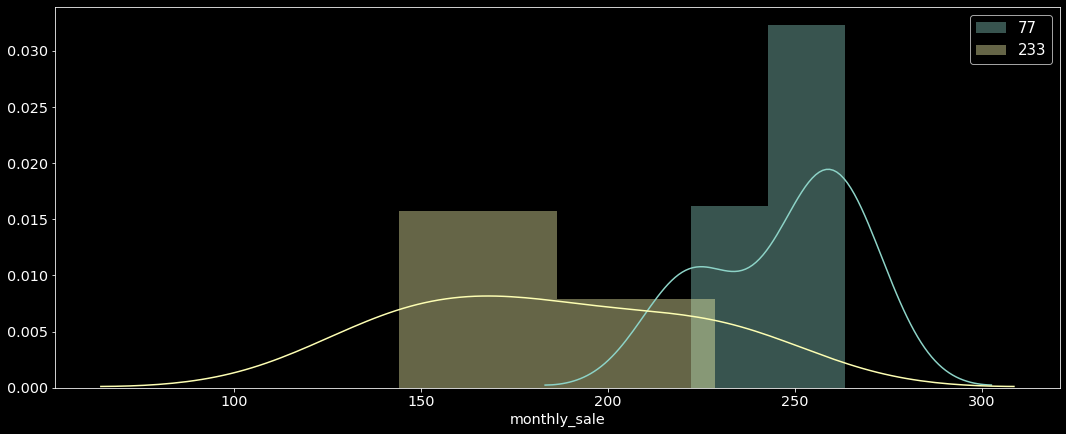

In [36]:
sns.distplot(trial_metrics_df.loc[77]['monthly_sale'])
sns.distplot(trial_metrics_df.loc[233]['monthly_sale'])
plt.legend(labels=['77','233'])

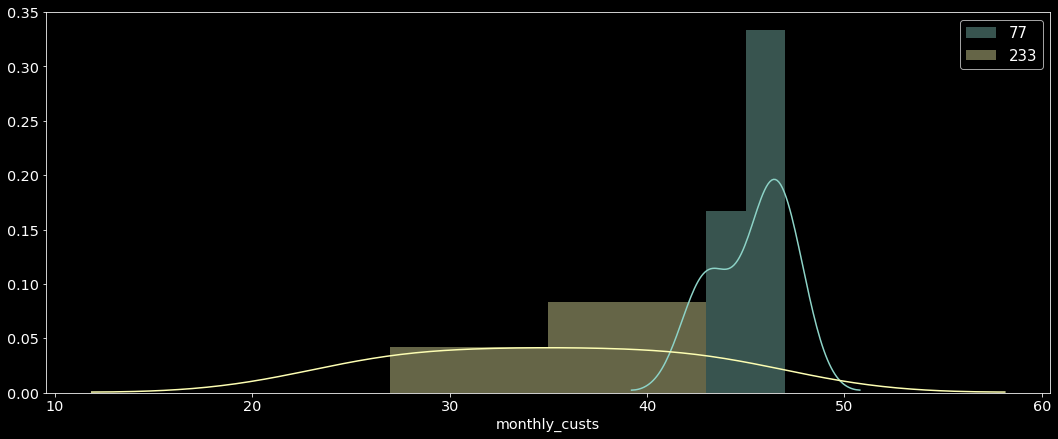

In [37]:
sns.distplot(trial_metrics_df.loc[77]['monthly_custs'])
sns.distplot(trial_metrics_df.loc[233]['monthly_custs'])
plt.legend(labels=['77','233'])

We can see that the distribution of monthly sale and monthly customers of both the stores in the trial period is much different than the distribution of monthly sale and monthly customers in pre-trial period.

The results show that the trial store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

We can also see that there is significant increase in sales of chips in trial stores in the trial period.

## Correlation with trial store: 86

In [38]:
corr_86 = calc_corr(86).drop(86)
corr_86.head()

,monthly_sale,monthly_custs,mean_corr
store_nbr,,,
155,0.852169,0.824667,0.838418
114,0.797520,0.875624,0.836572
260,0.851237,0.805041,0.828139
56,0.795140,0.799344,0.797242
120,0.891578,0.606359,0.748968


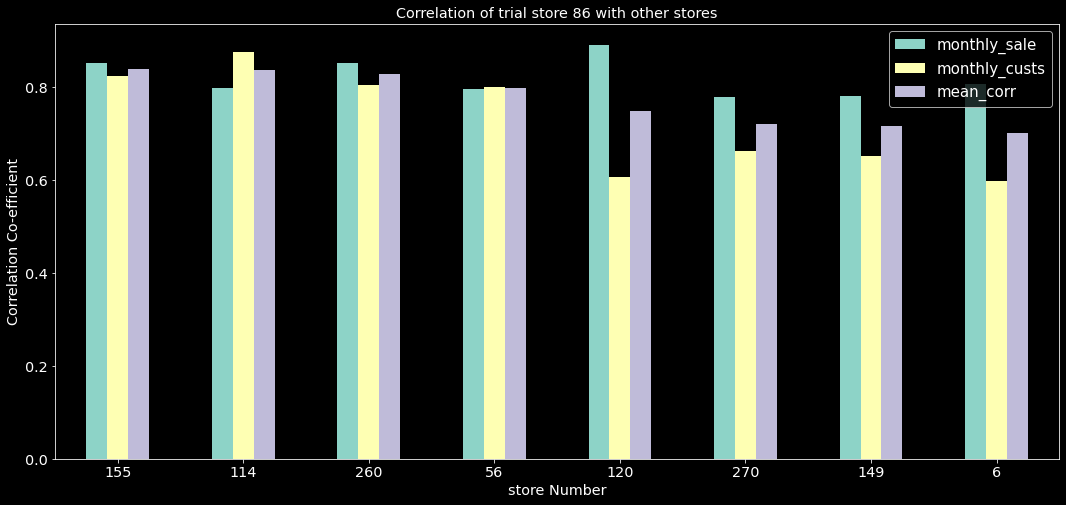

In [39]:
corr_86[corr_86['mean_corr'].abs() > 0.7].plot(kind = 'bar', rot = 0, figsize = (18, 8))
plt.title('Correlation of trial store 86 with other stores')
plt.xlabel('store Number')
plt.ylabel('Correlation Co-efficient')
plt.show()

The store '155' with the highest score is selected as the control store for trial store '86'.

Now let's quantify how related it is to the trial store by using plots and some stats. Since monthly sales and customers are only parameters we can monitor. Therefore we'll just see these two parameters.

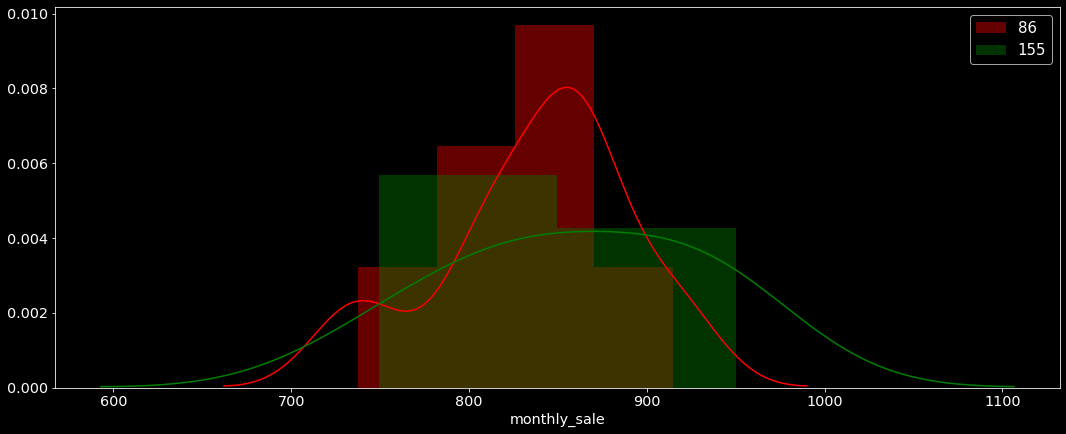

In [40]:
fig, ax = plt.subplots()
sns.distplot(metrics_df.loc[86]['monthly_sale'], color = 'r', ax = ax)
sns.distplot(metrics_df.loc[155]['monthly_sale'], color = 'g', ax = ax)
plt.legend(labels = ['86', '155'])
plt.show()

From the above plot we can see that there is difference in monthly sale in both the stores. But on avarage both the stores are similar.

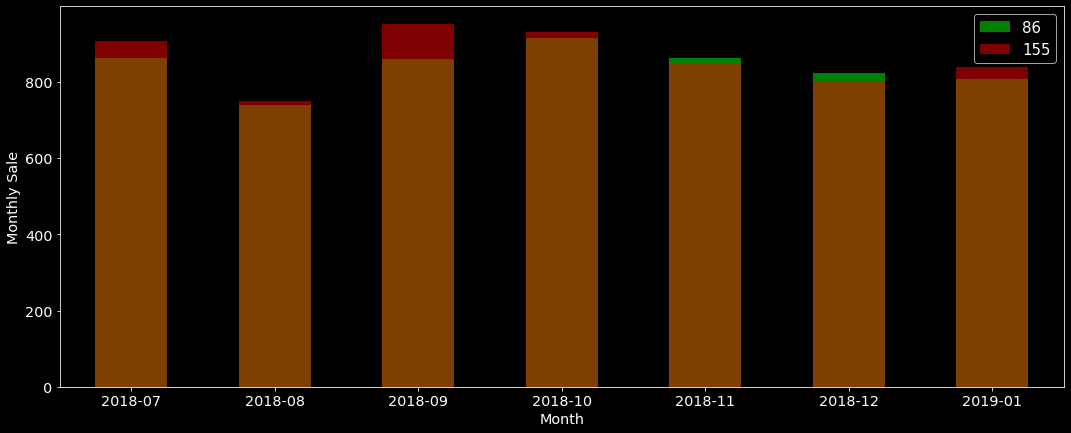

In [41]:
metrics_df.loc[86]['monthly_sale'].plot(kind = 'bar', color = 'g')
metrics_df.loc[155]['monthly_sale'].plot(kind = 'bar', color = 'r', alpha = 0.5)
plt.xticks(rotation = 0)
plt.xlabel('Month')
plt.ylabel('Monthly Sale')
plt.legend(labels = (86, 155))
plt.show()

Even though the monthly sale values are diffrent but we see a similar trend in the sales through out the period.

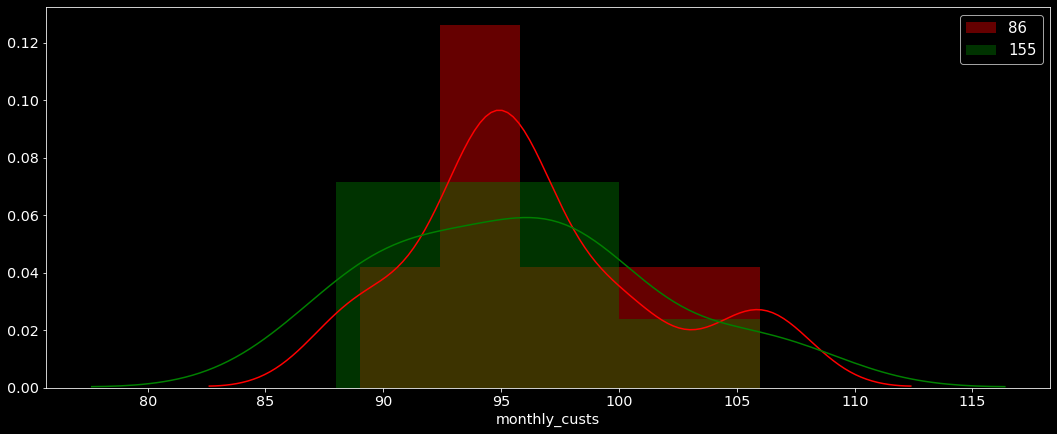

In [42]:
fig, ax = plt.subplots()
sns.distplot(metrics_df.loc[86]['monthly_custs'], color = 'r', ax = ax)
sns.distplot(metrics_df.loc[155]['monthly_custs'], color = 'g', ax = ax)
plt.legend(labels = ['86', '155'])
plt.show()

We can see that monthly customers are similar in both the stores.

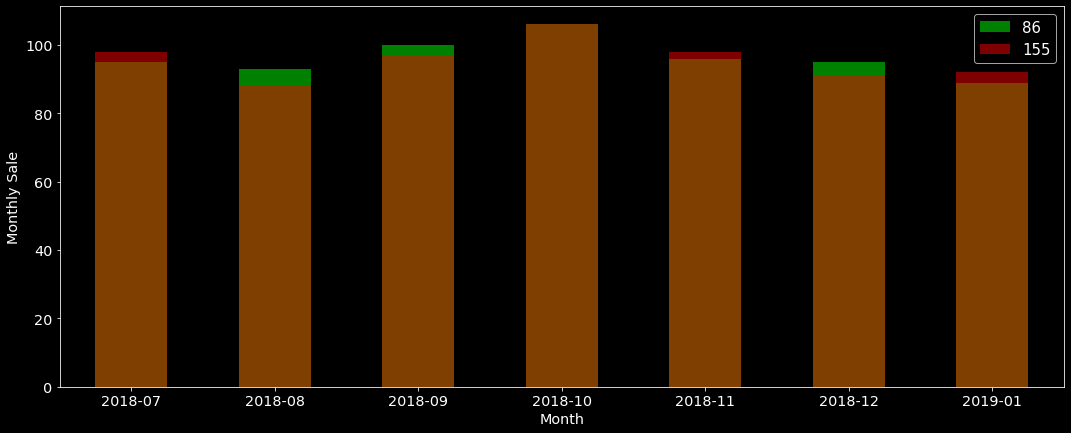

In [43]:
metrics_df.loc[86]['monthly_custs'].plot(kind = 'bar', color = 'g')
metrics_df.loc[155]['monthly_custs'].plot(kind = 'bar', color = 'r', alpha = 0.5)
plt.xticks(rotation = 0)
plt.xlabel('Month')
plt.ylabel('Monthly Sale')
plt.legend(labels = (86, 155))
plt.show()

Even the trend in the number of customers every month follows a similar trend between the stores.

Let our null hypothesis be that both the trial store and our selected control store are similar. Now if we want to reject the null hypothesis then we must have pvalue close to zero.

In [44]:
cols_under_consideration = ['monthly_sale', 'monthly_custs']
a=[]
for x in metrics_df[cols_under_consideration]:
    a.append(ks_2samp(metrics_df.loc[86][x], metrics_df.loc[155][x]))
a=pd.DataFrame(a, index = cols_under_consideration)
a.head()

,statistic,pvalue
monthly_sale,0.285714,0.962704
monthly_custs,0.285714,0.962704


From the dataframe above we can say that both are similar (pvalues are high close to 1). Hence we cannot reject our null hypothesis.

Assessment of Trial.

Now we'll compare the trial store with the control store in the trial period i.e. from Febraury 2019 to April 2019.

In [45]:
b = []
for x in trial_metrics_df[cols_under_consideration]:
    b.append(ks_2samp(trial_metrics_df.loc[86][x], trial_metrics_df.loc[155][x]))
b = pd.DataFrame(b, index = cols_under_consideration)
b.head()

,statistic,pvalue
monthly_sale,0.666667,0.6
monthly_custs,1.000000,0.1



Since all of the p-values are high (say more than 0.05), we reject the null hypothesis i.e. there means are significantly different.

Comparing each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [46]:
print('critical t-value for 95% confidence level:')
t.ppf(0.95, 6)

critical t-value for 95% confidence level:


1.9431802803927816

We can see that t-value is greater than 95 percentile for febraury to april.

The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

Let's plot the means for both the stores in trial period.

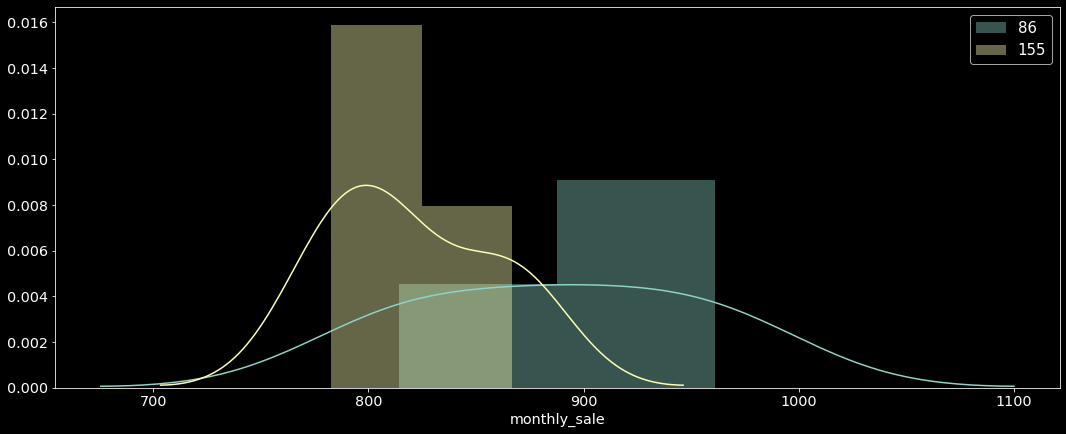

In [47]:
sns.distplot(trial_metrics_df.loc[86]['monthly_sale'])
sns.distplot(trial_metrics_df.loc[155]['monthly_sale'])
plt.legend(labels=['86','155'])

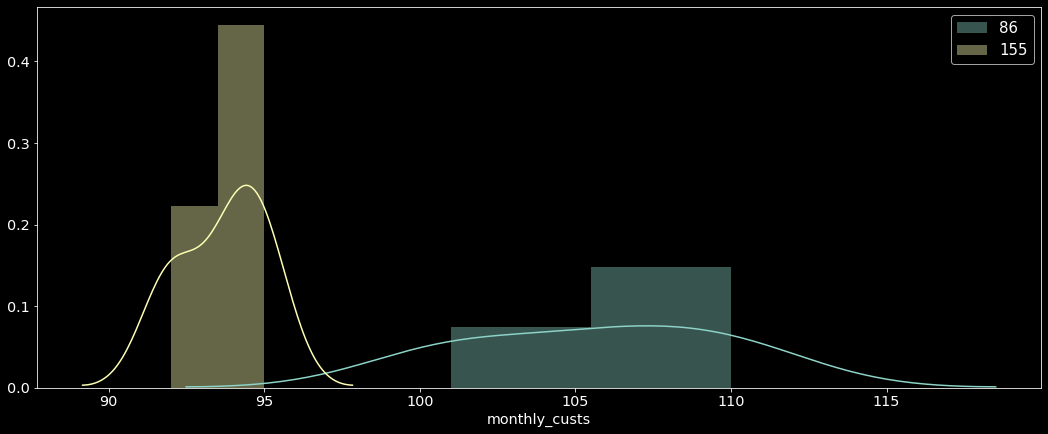

In [48]:
sns.distplot(trial_metrics_df.loc[86]['monthly_custs'])
sns.distplot(trial_metrics_df.loc[155]['monthly_custs'])
plt.legend(labels=['86','155'])

We can see that the distribution of monthly sale and monthly customers of both the stores in the trial period is much different than the distribution of monthly sale and monthly customers in pre-trial period.

The results show that the trial store 86 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

We can also see that there is significant increase in sales of chips in trial stores in the trial period.

## Correlation with trial store: 88

In [49]:
corr_88 = calc_corr(88).drop(88)
corr_88.head()

,monthly_sale,monthly_custs,mean_corr
store_nbr,,,
14,0.599664,0.975727,0.787695
141,0.718477,0.643611,0.681044
204,0.871969,0.458144,0.665057
1,0.846112,0.450833,0.648472
235,0.834842,0.430326,0.632584


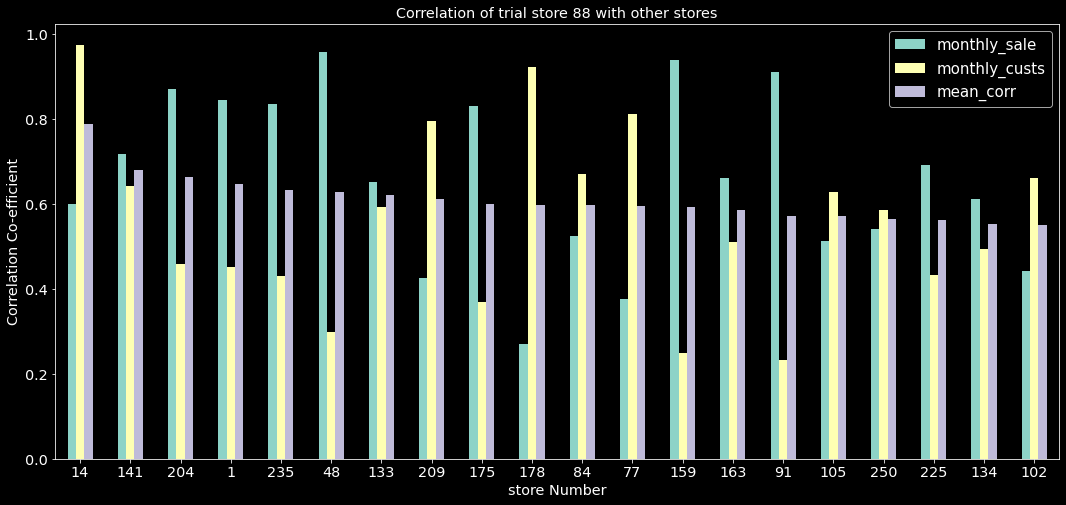

In [50]:
corr_88[corr_88['mean_corr'].abs() > 0.55].plot(kind = 'bar', rot = 0, figsize = (18, 8))
plt.title('Correlation of trial store 88 with other stores')
plt.xlabel('store Number')
plt.ylabel('Correlation Co-efficient')
plt.show()

The store '14' has the highest score but we'll consider store '237' as the control store since the monthly sales is much correlated with it. Therefore store '237' is selected as the control store for trial store '88'.

Now let's quantify how related it is to the trial store by using plots and some stats. Since monthly sales and customers are only parameters we can monitor. Therefore we'll just see these two parameters.

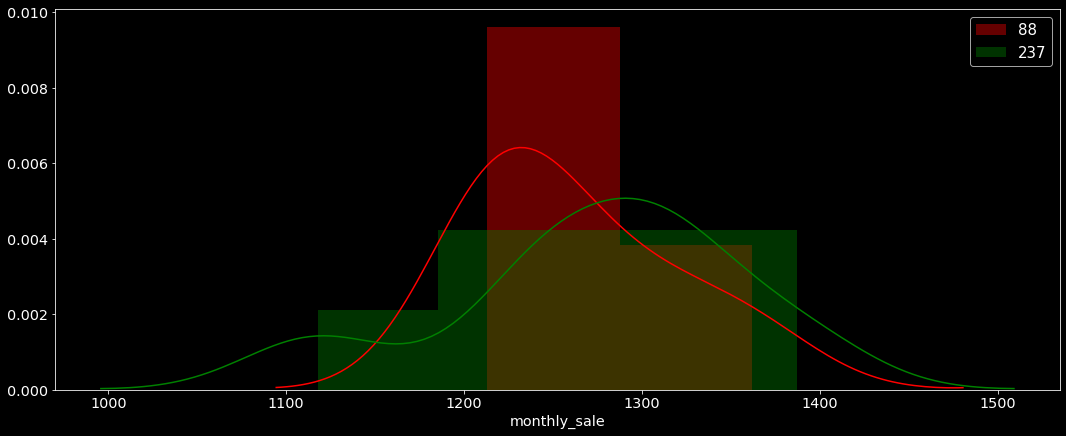

In [51]:
fig, ax = plt.subplots()
sns.distplot(metrics_df.loc[88]['monthly_sale'], color = 'r', ax = ax)
sns.distplot(metrics_df.loc[237]['monthly_sale'], color = 'g', ax = ax)
plt.legend(labels = ['88', '237'])
plt.show()

From the above plot we can see that there is difference in monthly sale in both the stores. But on avarage both the stores are similar.

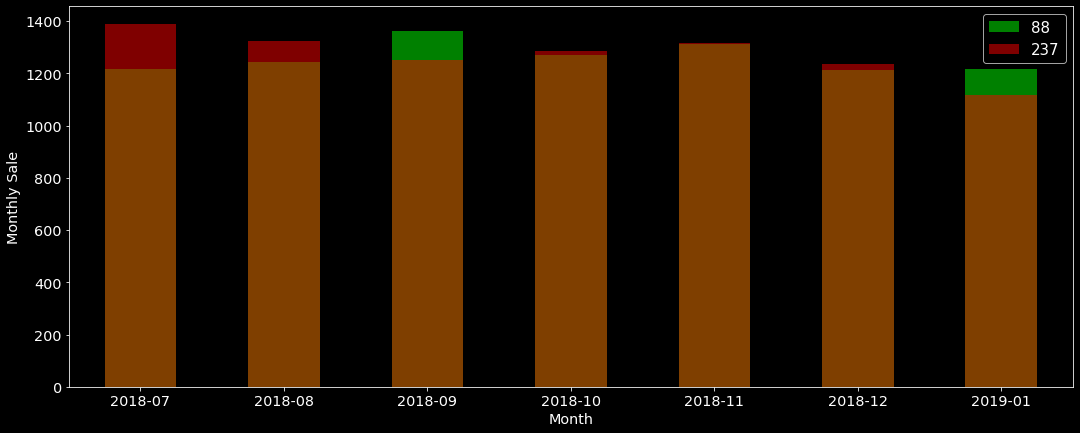

In [52]:
metrics_df.loc[88]['monthly_sale'].plot(kind = 'bar', color = 'g')
metrics_df.loc[237]['monthly_sale'].plot(kind = 'bar', color = 'r', alpha = 0.5)
plt.xticks(rotation = 0)
plt.xlabel('Month')
plt.ylabel('Monthly Sale')
plt.legend(labels = (88, 237))
plt.show()

Even though the monthly sale values are diffrent but we see a similar trend in the sales through out the period.

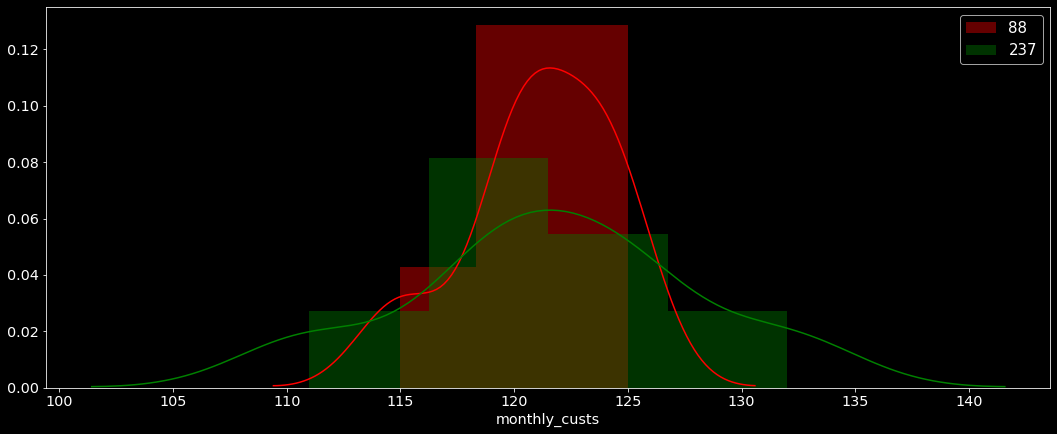

In [53]:
fig, ax = plt.subplots()
sns.distplot(metrics_df.loc[88]['monthly_custs'], color = 'r', ax = ax)
sns.distplot(metrics_df.loc[237]['monthly_custs'], color = 'g', ax = ax)
plt.legend(labels = ['88', '237'])
plt.show()

We can see that monthly customers are similar in both the stores.

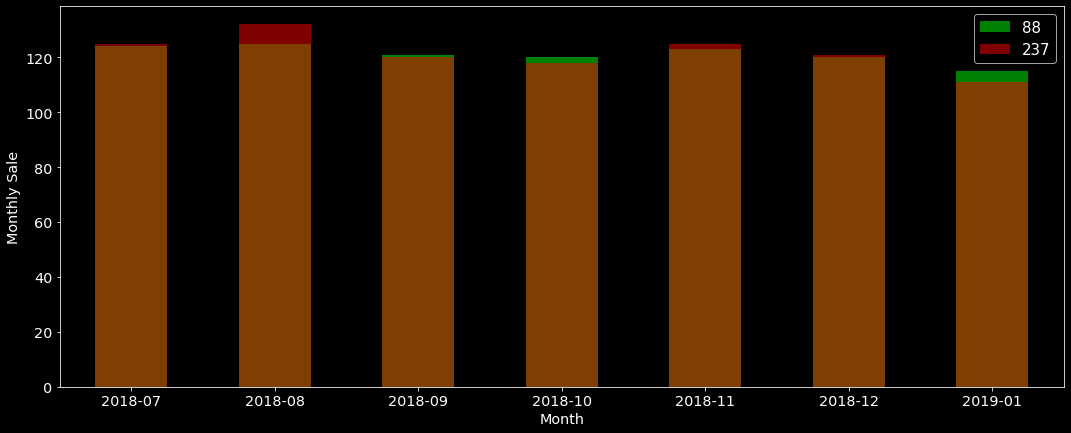

In [54]:
metrics_df.loc[88]['monthly_custs'].plot(kind = 'bar', color = 'g')
metrics_df.loc[237]['monthly_custs'].plot(kind = 'bar', color = 'r', alpha = 0.5)
plt.xticks(rotation = 0)
plt.xlabel('Month')
plt.ylabel('Monthly Sale')
plt.legend(labels = (88, 237))
plt.show()

Even the trend in the number of customers every month follows a similar trend between the stores.

Let our null hypothesis be that both the trial store and our selected control store are similar. Now if we want to reject the null hypothesis then we must have pvalue close to zero.

In [55]:
cols_under_consideration = ['monthly_sale', 'monthly_custs']
a=[]
for x in metrics_df[cols_under_consideration]:
    a.append(ks_2samp(metrics_df.loc[88][x], metrics_df.loc[237][x]))
a=pd.DataFrame(a, index = cols_under_consideration)
a.head()

,statistic,pvalue
monthly_sale,0.285714,0.962704
monthly_custs,0.285714,0.962704


From the dataframe above we can say that both are similar (pvalues are high close to 1). Hence we cannot reject our null hypothesis.

Assessment of Trial.

Now we'll compare the trial store with the control store in the trial period i.e. from Febraury 2019 to April 2019.

In [56]:
b = []
for x in trial_metrics_df[cols_under_consideration]:
    b.append(ks_2samp(trial_metrics_df.loc[88][x], trial_metrics_df.loc[237][x]))
b = pd.DataFrame(b, index = cols_under_consideration)
b.head()

,statistic,pvalue
monthly_sale,1.000000,0.1
monthly_custs,0.666667,0.6



Since all of the p-values are high (say more than 0.05), we reject the null hypothesis i.e. there means are significantly different.

Comparing each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [57]:
print('critical t-value for 95% confidence level:')
t.ppf(0.95, 6)

critical t-value for 95% confidence level:


1.9431802803927816

We can see that t-value is greater than 95 percentile for febraury to april.

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

Let's plot the means for both the stores in trial period.

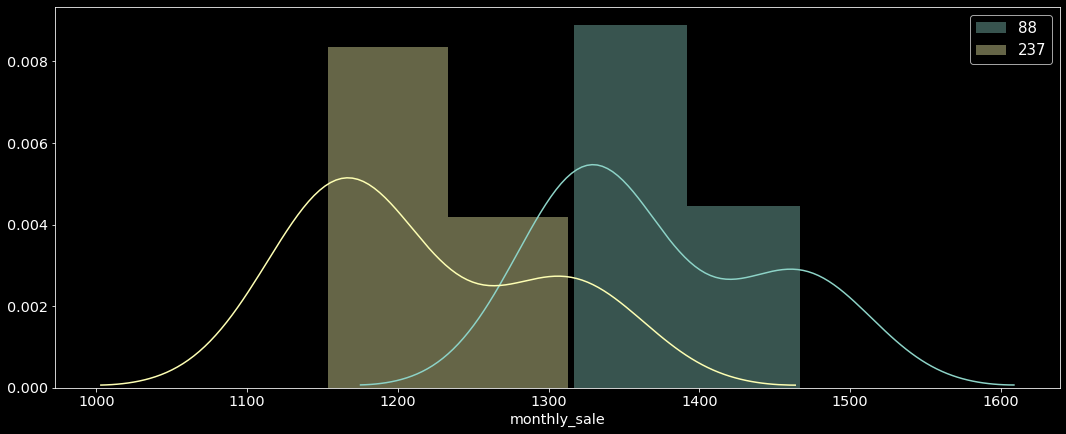

In [58]:
sns.distplot(trial_metrics_df.loc[88]['monthly_sale'])
sns.distplot(trial_metrics_df.loc[237]['monthly_sale'])
plt.legend(labels=['88','237'])

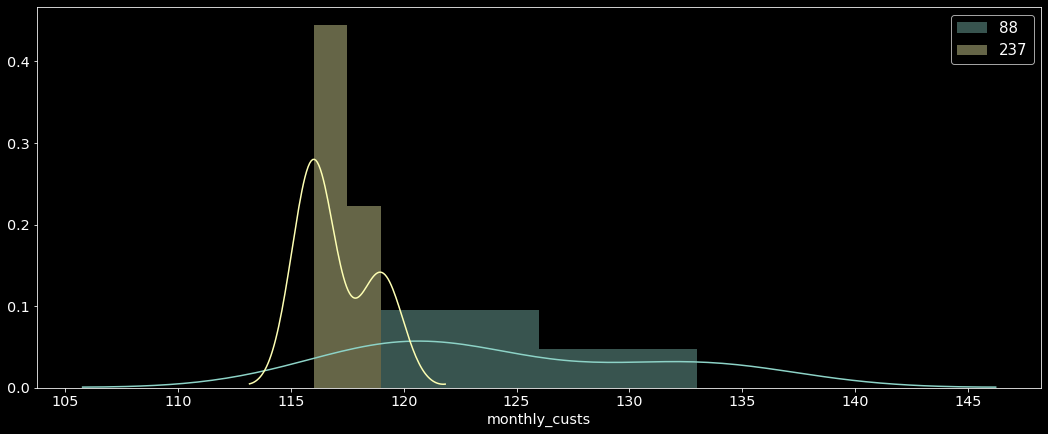

In [59]:
sns.distplot(trial_metrics_df.loc[88]['monthly_custs'])
sns.distplot(trial_metrics_df.loc[237]['monthly_custs'])
plt.legend(labels=['88','237'])

We can see that the distribution of monthly sale and monthly customers of both the stores in the trial period is much different than the distribution of monthly sale and monthly customers in pre-trial period.

The results show that the trial store 88 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

We can also see that there is significant increase in sales of chips in trial stores in the trial period.

Conclusion

The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.